In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import os
from sysidentpy.model_structure_selection import FROLS
from sysidentpy.basis_function import Polynomial
from sysidentpy.parameter_estimation import (
    LeastSquares,
    TotalLeastSquares,
    RecursiveLeastSquares,
    NonNegativeLeastSquares,
    LeastMeanSquares,
    AffineLeastMeanSquares,
)
from sysidentpy.metrics import root_relative_squared_error
from sysidentpy.utils.display_results import results
from sysidentpy.utils.plotting import plot_residues_correlation, plot_results
from sysidentpy.residues.residues_correlation import (
    compute_residues_autocorrelation,
    compute_cross_correlation,
)
from sysidentpy.utils.save_load import save_model, load_model

from hmmlearn.hmm import GaussianHMM
from statsmodels.tsa.stattools import adfuller
from statsmodels.regression.linear_model import OLS
from statsmodels.tools.tools import add_constant
from sklearn.model_selection import TimeSeriesSplit
from itertools import product

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ConstantKernel, ExpSineSquared
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

warnings.filterwarnings('ignore')
plt.rcParams["font.family"] = "Times New Roman"

In [2]:
# read data from pickle 
building_results = pd.read_pickle('C:/Users/yangzhec/OneDrive - KTH/Projects/HYSTORE/PCM_flexibility_mdp/data/building_results.pkl')
office_elec = pd.read_pickle('C:/Users/yangzhec/OneDrive - KTH/Projects/HYSTORE/PCM_flexibility_mdp/data/office_load.pkl')

In [3]:
# calculate the average temp by assuming single thermal zone
building_results['avetemp'] = (building_results['TAIR_Office1             '] + building_results['TAIR_Office2             '] +
                             building_results['TAIR_Office1             '] + building_results['TAIR_Office4             '] +
                             building_results['TAIR_Office5             '] + building_results['TAIR_Office6             '] +
                             building_results['TAIR_Office7             '] + building_results['TAIR_Office8             ']) / 8

In [4]:
# seperate cooling season data (Jun, Jul, and Aug) 
office_elec_cs = office_elec[(office_elec.index.month==5) | (office_elec.index.month==6) | (office_elec.index.month==7) | (office_elec.index.month==8)]
building_results_cs = building_results[(building_results.index.month==5) | (building_results.index.month==6) | (building_results.index.month==7) | (building_results.index.month==8)]

<Axes: >

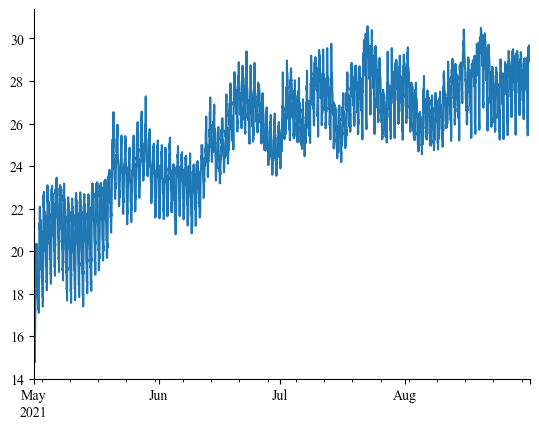

In [5]:
building_results_cs['avetemp'].plot()

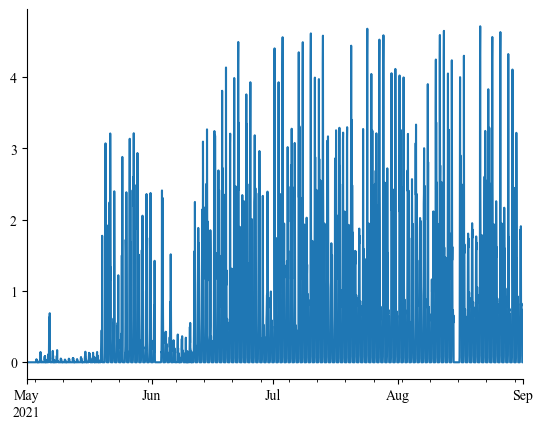

In [12]:
office_elec_cs = office_elec_cs.resample('1H', label='right', closed='right').mean()

office_elec_cs['Electricity Demand-TOT Cooling'].plot()

office_elec_cs.to_pickle('./office_load_hourly.pkl')

In [14]:
total_df = pd.concat([building_results_cs, office_elec_cs], axis=1)
#total_df['Electricity Demand-TOT Cooling'].shift(-1)
total_df.dropna(inplace=True, axis=0)

In [6]:
# split training and validation sets (Jun Jul as training, Aug as validation)
train_df = total_df[total_df.index.month!=8]
test_df = total_df[total_df.index.month==8]

X_train = train_df[['Electricity Demand-TOT Cooling', 'T                        ']].values.astype(float)
y_train = train_df['avetemp'].values.reshape(-1,1).astype(float)

X_test = test_df[['Electricity Demand-TOT Cooling', 'T                        ']].values.astype(float)
y_test = test_df['avetemp'].values.reshape(-1,1).astype(float)

Polynomial with FROLS estimator

In [7]:
basis_function = Polynomial(degree=2)
estimator = LeastSquares()

frols_model = FROLS(
    order_selection=True,
    n_terms=10,
    ylag=2,
    xlag=[[1, 2], [1, 2]],
    info_criteria="aic",
    estimator=estimator,
    basis_function=basis_function,
)

frols_model.fit(X=X_train, y=y_train)

In [8]:
yhat = frols_model.predict(X=X_test, y=y_test, steps_ahead=1)
rrse = root_relative_squared_error(y_test, yhat)
print(rrse)

0.1822386182167835


In [9]:
r = pd.DataFrame(
    results(
        frols_model.final_model,
        frols_model.theta,
        frols_model.err,
        frols_model.n_terms,
        err_precision=8,
        dtype="sci",
    ),
    columns=["Regressors", "Parameters", "ERR"],
)
print(r)

      Regressors   Parameters             ERR
0         y(k-1)   1.4072E+00  9.99920656E-01
1         y(k-2)  -4.2461E-01  1.49227836E-05
2        x2(k-1)   1.5524E+00  1.15632661E-06
3  x2(k-2)y(k-1)   1.5755E-03  8.80612151E-07
4  x2(k-2)y(k-2)   5.6091E-02  5.56023809E-07
5        x2(k-2)  -1.5262E+00  2.91227332E-07
6  x2(k-1)y(k-2)  -5.7973E-02  7.65675263E-07
7      x1(k-1)^2   2.4724E-02  3.09348772E-07
8  x1(k-1)y(k-1)  -1.1731E-01  7.95267384E-07
9  x1(k-1)y(k-2)   1.1421E-01  4.43073777E-07


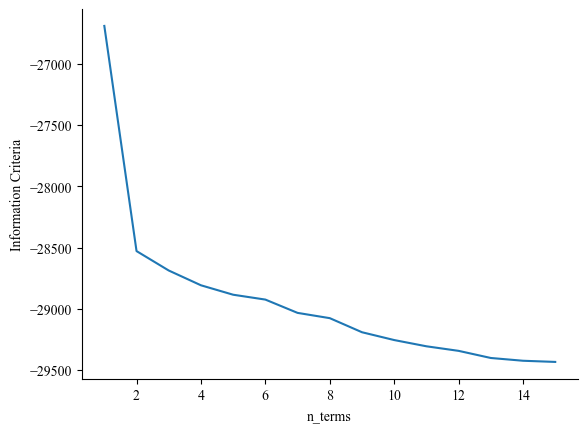

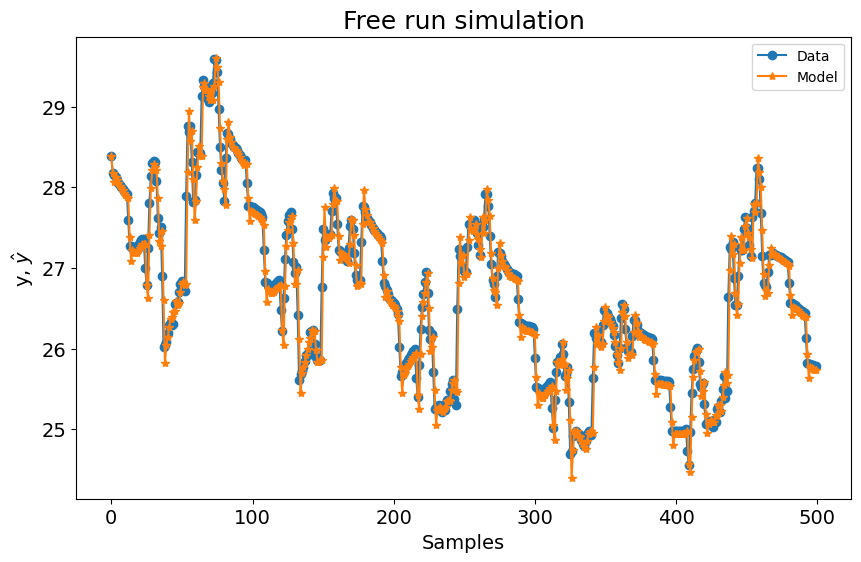

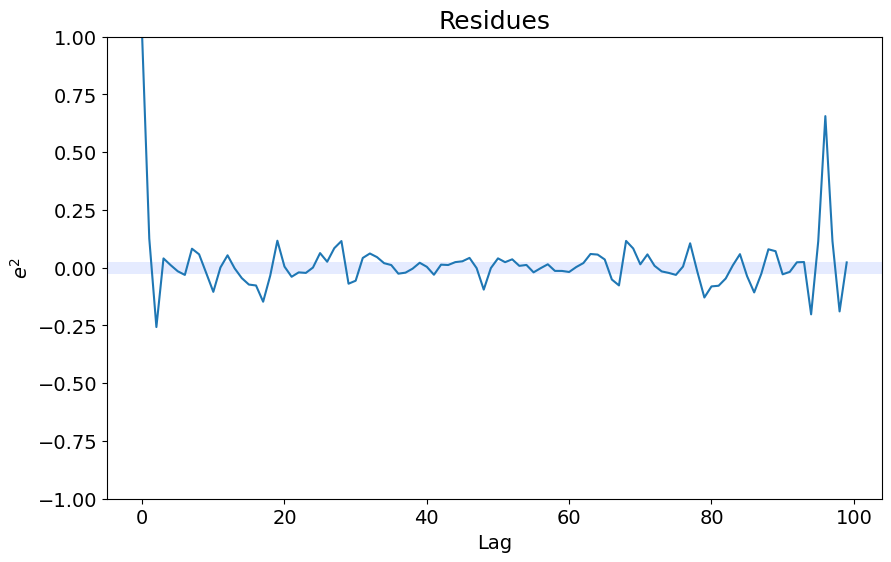

In [10]:
xaxis = np.arange(1, frols_model.n_info_values + 1)
plt.plot(xaxis, frols_model.info_values)
plt.xlabel("n_terms")
plt.ylabel("Information Criteria")
plot_results(y=y_test, yhat=yhat, n=500)
ee = compute_residues_autocorrelation(y_test, yhat)
plot_residues_correlation(data=ee, title="Residues", ylabel="$e^2$")

In [12]:
save_model(model=frols_model, file_name="indoor_frols.syspy")


 Original model 
       Regressors   Parameters             ERR
0         y(k-1)   1.4072E+00  9.99920656E-01
1         y(k-2)  -4.2461E-01  1.49227836E-05
2        x2(k-1)   1.5524E+00  1.15632661E-06
3  x2(k-2)y(k-1)   1.5755E-03  8.80612151E-07
4  x2(k-2)y(k-2)   5.6091E-02  5.56023809E-07
5        x2(k-2)  -1.5262E+00  2.91227332E-07
6  x2(k-1)y(k-2)  -5.7973E-02  7.65675263E-07
7      x1(k-1)^2   2.4724E-02  3.09348772E-07
8  x1(k-1)y(k-1)  -1.1731E-01  7.95267384E-07
9  x1(k-1)y(k-2)   1.1421E-01  4.43073777E-07

 Model Loaded from file 
       Regressors   Parameters             ERR
0         y(k-1)   1.4072E+00  9.99920656E-01
1         y(k-2)  -4.2461E-01  1.49227836E-05
2        x2(k-1)   1.5524E+00  1.15632661E-06
3  x2(k-2)y(k-1)   1.5755E-03  8.80612151E-07
4  x2(k-2)y(k-2)   5.6091E-02  5.56023809E-07
5        x2(k-2)  -1.5262E+00  2.91227332E-07
6  x2(k-1)y(k-2)  -5.7973E-02  7.65675263E-07
7      x1(k-1)^2   2.4724E-02  3.09348772E-07
8  x1(k-1)y(k-1)  -1.1731E-01  7.9

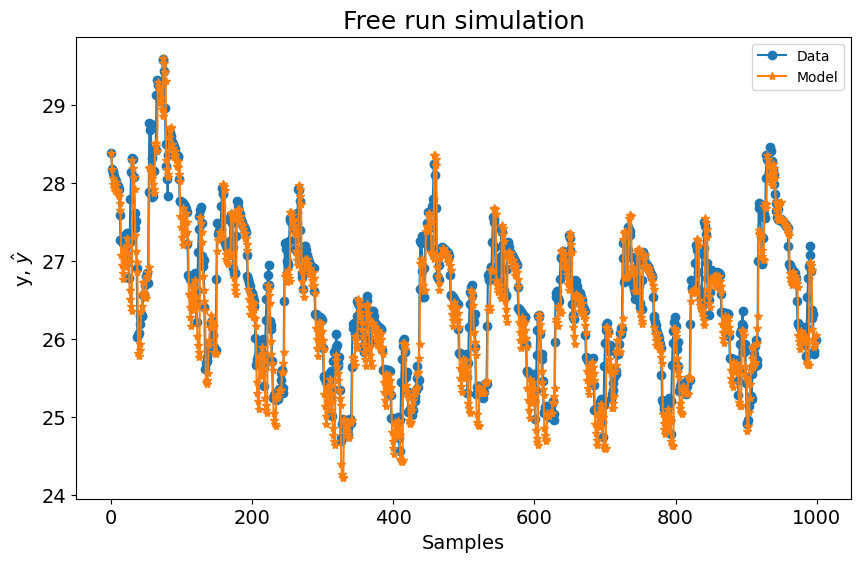

In [13]:
loaded_model = load_model(file_name="indoor_frols.syspy")
# Predicting output with loaded_model
yhat_loaded = loaded_model.predict(X=X_test, y=y_test, steps_ahead=4)

r_loaded = pd.DataFrame(
    results(
        loaded_model.final_model,
        loaded_model.theta,
        loaded_model.err,
        loaded_model.n_terms,
        err_precision=8,
        dtype="sci",
    ),
    columns=["Regressors", "Parameters", "ERR"],
)

# Printing both: original model and model loaded from file
print("\n Original model \n", r)
print("\n Model Loaded from file \n", r_loaded)

# Checking predictions from both: original model and model loaded from file
if (yhat == yhat_loaded).all():
    print("\n Predictions are the same!")

# Ploting results
plot_results(y=y_test, yhat=yhat_loaded, n=1000)

Gaussian Process

In [44]:
data_df = total_df.copy()

data_df['indoor_temp_normalized'] = (data_df['avetemp'] - data_df['avetemp'].mean()) / data_df['avetemp'].std()
data_df['outdoor_temp_normalized'] = (data_df['T                        '] - data_df['T                        '].mean()) / data_df['T                        '].std()
data_df['el_normalized'] = (data_df['Electricity Demand-TOT Cooling'] - data_df['Electricity Demand-TOT Cooling'].mean()) / data_df['Electricity Demand-TOT Cooling'].std()

# Define lagged features
max_lags = 10
for lag in range(1, max_lags + 1):
    data_df[f"indoor_temp_lag_{lag}"] = data_df["indoor_temp_normalized"].shift(lag)
    data_df[f"outdoor_temp_lag_{lag}"] = data_df["outdoor_temp_normalized"].shift(lag)
    data_df[f"el_lag_{lag}"] = data_df["el_normalized"].shift(lag)

# Drop NaN values after shifting
data_df = data_df.apply(pd.to_numeric, errors='coerce')
data_df.dropna(inplace=True)

In [59]:
max_lag = 2  # Consider up to 6 past time steps
for lag in range(1, max_lag + 1):
    data_df[f"indoor_temp_lag_{lag}"] = data_df["indoor_temp_normalized"].shift(lag)
    data_df[f"outdoor_temp_lag_{lag}"] = data_df["outdoor_temp_normalized"].shift(lag)
    data_df[f"electricity_lag_{lag}"] = data_df["el_normalized"].shift(lag)

# Drop NaN values (due to lagging)
data_df.dropna(inplace=True)

In [60]:
scaler = StandardScaler()
features = [f"indoor_temp_lag_{i}" for i in range(1, max_lag + 1)] + ["outdoor_temp_normalized", "el_normalized"]
data_df[features] = scaler.fit_transform(data_df[features])

In [61]:
X = data_df[features]
y = data_df["indoor_temp_normalized"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [63]:
kernel = (
    ConstantKernel(1.0) * RBF(length_scale=1.0)  # Smooth trend
    + WhiteKernel(noise_level=0.1)  # Noise capture
)

# Train Gaussian Process Regressor
gpr = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, alpha=1e-4)
gpr.fit(X_train, y_train)

# Predict on test set
y_pred, sigma = gpr.predict(X_test, return_std=True)

KeyboardInterrupt: 